In [0]:
#!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
#!pip3 install torchvision
#!pip install GPy
#import GPy
import pandas as pd
import zipfile
import urllib.request
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from sklearn.model_selection import KFold

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from google.colab import files
%config InlineBackend.figure_format = 'svg'

In [2]:
torch.cuda.device(0)
torch.cuda.get_device_name(torch.cuda.current_device())

'Tesla T4'

In [0]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

In [0]:
def log_gaussian_loss(output, target, sigma, no_dim, sum_reduce=True):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma) - 0.5*no_dim*np.log(2*np.pi)
    
    if sum_reduce:
        return -(log_coeff + exponent).sum()
    else:
        return -(log_coeff + exponent)


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

#Bayesian Linear

In [0]:
class BayesLinear(nn.Module):
    def __init__(self, input_dim, output_dim, prior):
        super(BayesLinear, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior = prior
        
        scale = (2/self.input_dim)**0.5
        rho_init = np.log(np.exp((2/self.input_dim)**0.5) - 1)
        self.weight_mus = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.01, 0.01))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-3, -3))
        
        self.bias_mus = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.01, 0.01))
        self.bias_rhos = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-4, -3))
        
    def return_mus():
        return self.weight_mus
        
    def forward(self, x, sample = True):
        
        if sample:
            # sample gaussian noise for each weight and each bias. epsilon is drawn from normal distribution
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            bias_epsilons =  Variable(self.bias_mus.data.new(self.bias_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters [softplus function]
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            bias_stds = torch.log(1 + torch.exp(self.bias_rhos))
            
            # obtain weight and bias samples from the posterior from the sampled noise and mus/stds: by transforming the epsilon
            #[applying the local reparametrization trick for backprop to work]
            
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            bias_sample = self.bias_mus + bias_epsilons*bias_stds
            
            output = torch.mm(x, weight_sample) + bias_sample
            
            # computing the KL loss term for weight
            prior_cov, varpost_cov = self.prior.sigma**2, weight_stds**2
            KL_loss = 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*weight_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.weight_mus - self.prior.mu)**2/prior_cov).sum()
            
            # computing the KL loss term for bias
            prior_cov, varpost_cov = self.prior.sigma**2, bias_stds**2
            KL_loss = KL_loss + 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*bias_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.bias_mus - self.prior.mu)**2/prior_cov).sum()
            
            return output, KL_loss
        
        else:
            output = torch.mm(x, self.weight_mus) + self.bias_mus
            return output, KL_loss
        
    def sample_layer(self, no_samples):
        all_samples = []
        for i in range(no_samples):
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            
            all_samples += weight_sample.view(-1).cpu().data.numpy().tolist()
            
        return all_samples

In [0]:
class BNN_Model_Wrapper:
    def __init__(self, network, learn_rate, batch_size, no_batches):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = network
        self.network.cuda()
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.learn_rate)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)

            # calculate fit loss based on mean and standard deviation of output
            fit_loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
            fit_loss_total = fit_loss_total + fit_loss
        
        KL_loss_total = KL_loss_total/self.no_batches
        total_loss = (fit_loss_total + KL_loss_total)/(no_samples*x.shape[0])
        total_loss.backward()
        self.optimizer.step()

        return fit_loss_total/no_samples, KL_loss_total
    
    def get_loss_and_rmse(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        means, stds = [], []
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)
            means.append(output[:, :1, None])
            stds.append(output[:, 1:, None].exp())
            
        means, stds = torch.cat(means, 2), torch.cat(stds, 2)
        mean = means.mean(dim=2)
        std = (means.var(dim=2) + stds.mean(dim=2)**2)**0.5
            
        # calculate fit loss based on mean and standard deviation of output
        logliks = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1, sum_reduce=False)
        rmse = float((((mean - y)**2).mean()**0.5).cpu().data)
        new_output = [mean, std]
        return logliks, rmse, new_output #return the mean and std of the output

In [0]:
def evaluate_accuracy(data_iterator, net, layer_params):
    numerator = 0.
    denominator = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1, 784))
        label = label.as_in_context(ctx)
        output = net(data, layer_params)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
    return (numerator / denominator).asscalar()
  


#Model

In [0]:
class BNN_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units):
        super(BNN_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        self.layer1 = BayesLinear(input_dim, num_units, gaussian(0, 1))
        self.layer2 = BayesLinear(num_units, num_units, gaussian(0, 1))
        self.layer3 = BayesLinear(num_units, 2*output_dim, gaussian(0, 1))
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
    
    def forward(self, x):
        
        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, KL_loss = self.layer1(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        
        return x, KL_loss_total      

#Model training

In [0]:

def train_BNN(data, n_splits, num_epochs, num_units, learn_rate, log_every):
    kf = KFold(n_splits=n_splits)
    in_dim = data.shape[1] - 1
    train_logliks, test_logliks = [], []
    train_rmses, test_rmses = [], []
    xtrain_rmse, xtest_rmse = [], []
    xtrain_loss, xtest_loss = [],[]
    
    
    #dataset splitting into training (90%) and testing(10%)
    split = np.random.rand(len(data)) < 0.9   #10% of data will be for testing
    train = data[split]
    test = data[~split]
    in_dim = data.shape[1] - 1
    x_train, y_train = train[:, :in_dim], train[:, in_dim:]
    x_test, y_test = test[:, :in_dim], test[:, in_dim:]
    print(x_train.shape)
    print(y_train.shape)

    # Normalize the data
    x_means, x_stds = x_train.mean(axis = 0), x_train.var(axis = 0)**0.5
    y_means, y_stds = y_train.mean(axis = 0), y_train.var(axis = 0)**0.5
    x_train = (x_train - x_means)/x_stds
    y_train = (y_train - y_means)/y_stds
    x_test = (x_test - x_means)/x_stds
    y_test = (y_test - y_means)/y_stds


    num_epochs, batch_size, nb_train = num_epochs, len(x_train), len(x_train)
    
    net = BNN_Model_Wrapper(network=BNN_Model(input_dim=x_test.shape[-1], output_dim=1, num_units=num_units),
                                            learn_rate=1e-2, batch_size=batch_size, no_batches=1)

    fit_loss_train = np.zeros(num_epochs)
    KL_loss_train = np.zeros(num_epochs)
    total_loss = np.zeros(num_epochs)

    best_net, best_loss = None, float('inf')

    print(len(x_train))
    print(len(x_test))

    #fit model for the specified epochs
    for i in range(num_epochs):

        fit_loss, KL_loss = net.fit(x_train, y_train, no_samples = 20)
        fit_loss_train[i] += fit_loss.cpu().data.numpy()
        KL_loss_train[i] += KL_loss.cpu().data.numpy()

        total_loss[i] = fit_loss_train[i] + KL_loss_train[i]

        if fit_loss < best_loss:
            best_loss = fit_loss
            best_net = copy.deepcopy(net.network)

        if i % log_every == 0 or i == num_epochs - 1:

            train_losses, train_rmse, train_pred = net.get_loss_and_rmse(x_train, y_train, 20)
            test_losses, test_rmse, test_pred = net.get_loss_and_rmse(x_test, y_test, 20)
            
            train_rmse_score = y_stds*train_rmse
            test_rmse_score = y_stds*test_rmse

            print('Epoch: %s/%d, Train loglik = %.3f, Test loglik = %.3f, Train RMSE = %.3f, Test RMSE = %.3f' %\
                  (str(i+1).zfill(3), num_epochs, -train_losses.mean() - np.log(y_stds)[0],
                   -test_losses.mean() - np.log(y_stds)[0], train_rmse_score, test_rmse_score))

        xtrain_rmse.append(train_rmse_score)
        xtest_rmse.append(test_rmse_score)
        
        xtrain_loss.append(train_losses.mean())
        xtest_loss.append(test_losses.mean())
        
        
        #evaluation of accuracy
        '''
        test_accuracy = evaluate_accuracy(x_test, net, mus)
        train_accuracy = evaluate_accuracy(x_train, net, mus)
        train_acc.append(np.asscalar(train_accuracy))
        test_acc.append(np.asscalar(test_accuracy))
        print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" %\
          (e, moving_loss, train_accuracy, test_accuracy))
        '''

    train_logliks.append((train_losses.cpu().data.numpy().mean() + np.log(y_stds)[0]))
    test_logliks.append((test_losses.cpu().data.numpy().mean() + np.log(y_stds)[0]))

    train_rmses.append(y_stds*train_rmse)
    test_rmses.append(y_stds*test_rmse)



    print('Train log. lik. = %6.3f +/- %6.3f' % (-np.array(train_logliks).mean(), np.array(train_logliks).var()**0.5))
    print('Test  log. lik. = %6.3f +/- %6.3f' % (-np.array(test_logliks).mean(), np.array(test_logliks).var()**0.5))
    print('Train RMSE      = %6.3f +/- %6.3f' % (np.array(train_rmses).mean(), np.array(train_rmses).var()**0.5))
    print('Test  RMSE      = %6.3f +/- %6.3f' % (np.array(test_rmses).mean(), np.array(test_rmses).var()**0.5))
    
    #plot the train and test rmse
    plt.plot(xtrain_rmse, label = 'Train')
    plt.plot(xtest_rmse, label = 'Test')
    
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('RMSE', fontsize=10)
    plt.legend()
    
    plt.show()

    return x_train, y_train, x_test, y_test, test_pred, best_net
  


#Evaluation

In [0]:

def evaluation(y_test, test_pred):
  mean = test_pred [0]
  std = test_pred [1]
  print (mean.shape)
  print (std.shape)
  print (y_test.shape)
  
  #pred = test_pred.data.cpu().numpy()   #.squeeze(1) #use .cpu() to bring back to cpu from the cuda
  #print (pred.shape)
  #y_u_pred = pred[:,0]
  #y_l_pred = pred[:,1]
  #print (y_u_pred.shape)
  #print (y_l_pred.shape)
  
  mean_np = mean.data.cpu().numpy()
  std_np = std.data.cpu().numpy()
  
  #calculate the upper and lower bounds of y using 95% prediction interval
  
  y_u_pred = mean_np + (std_np * 1.96)  #upper 95% limit
  y_l_pred = mean_np - (std_np * 1.96)  #lower 95% limit
  print (y_u_pred.shape)
  print (y_l_pred.shape)
    
  y_val = y_test
  print (y_val.shape)
  K_u = y_u_pred > y_val
  K_l = y_l_pred < y_val
  #print(K_l.shape)
  #print (K_l)
  y_all_cap = K_u * K_l
  #print (y_all_cap)
  #PICP = torch.sum(y_all_cap)        #torch.sum
  #print (PICP.item())
  #PICP = torch.sum(y_all_cap)
  #PICP = np.sum(y_all_cap)/y_l_pred.shape[0]
  #print (PICP)
  PICP = np.mean(K_u * K_l)
  MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
  return PICP, MPIW

# Housing dataset

In [0]:
np.random.seed(0)
url_housing = 'https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/boston_housing.txt'
data_housing = pd.read_csv(url_housing, header=0, delimiter="\s+").values
#data = data[np.random.permutation(np.arange(len(data)))]

(448, 13)
(448, 1)
448
57
Epoch: 001/100, Train loglik = -3.652, Test loglik = -3.565, Train RMSE = 9.284, Test RMSE = 8.157
Epoch: 011/100, Train loglik = -3.114, Test loglik = -3.069, Train RMSE = 5.479, Test RMSE = 5.090
Epoch: 021/100, Train loglik = -2.832, Test loglik = -2.829, Train RMSE = 4.175, Test RMSE = 4.194
Epoch: 031/100, Train loglik = -2.613, Test loglik = -2.677, Train RMSE = 4.007, Test RMSE = 3.650
Epoch: 041/100, Train loglik = -2.608, Test loglik = -2.630, Train RMSE = 3.697, Test RMSE = 3.583
Epoch: 051/100, Train loglik = -2.428, Test loglik = -2.466, Train RMSE = 3.661, Test RMSE = 3.212
Epoch: 061/100, Train loglik = -2.338, Test loglik = -2.618, Train RMSE = 3.558, Test RMSE = 3.198
Epoch: 071/100, Train loglik = -2.398, Test loglik = -2.397, Train RMSE = 3.532, Test RMSE = 3.119
Epoch: 081/100, Train loglik = -2.404, Test loglik = -2.396, Train RMSE = 3.461, Test RMSE = 3.013
Epoch: 091/100, Train loglik = -2.287, Test loglik = -2.453, Train RMSE = 3.395, Te

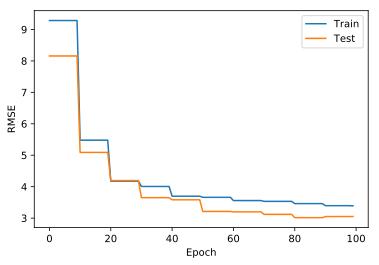

In [12]:
x_train_housing, y_train_housing, x_test_housing, y_test_housing, test_pred_housing, model_housing = train_BNN(data_housing, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

In [13]:

PICP_housing, MPIW_housing = evaluation (y_test_housing, test_pred_housing)
print ('PICP: ', PICP_housing)
print ('MPIW: ', MPIW_housing)

torch.Size([57, 1])
torch.Size([57, 99])
(57, 1)
(57, 99)
(57, 99)
(57, 1)
PICP:  0.9463051568314726
MPIW:  1.363


# Concrete dataset

In [0]:
np.random.seed(0)
url_concrete = 'https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/concrete.txt'
data_concrete = pd.read_csv(url_concrete, header=0, delimiter="\s+").values
#data = data[np.random.permutation(np.arange(len(data)))]


In [0]:
x_train_concrete, y_train_concrete, x_test_concrete, y_test_concrete, test_pred_concrete, model_concrete = train_BNN(data_concrete, n_splits=10, num_epochs=400, num_units=100, learn_rate=1e-2, log_every=10)

In [0]:
PICP_concrete, MPIW_concrete = evaluation (y_test_concrete, test_pred_concrete)
print ('PICP: ', PICP_concrete)
print ('MPIW: ', MPIW_concrete)

# Energy heating load dataset

In [0]:
np.random.seed(0)
url_energy = 'https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/energy_heating_load.txt'
data_energy = pd.read_csv(url_energy, header=0, delimiter="\s+").values
#data = data[np.random.permutation(np.arange(len(data)))]


In [0]:
x_train_energy, y_train_energy, x_test_energy, y_test_energy, test_pred_energy, model_energy = train_BNN(data_energy, n_splits=10, num_epochs=400, num_units=100, learn_rate=1e-2, log_every=10)


In [0]:
PICP_energy, MPIW_energy = evaluation (y_test_energy, test_pred_energy)
print ('PICP: ', PICP_energy)
print ('MPIW: ', MPIW_energy)

# Power dataset

In [0]:
np.random.seed(0)
url_power = 'https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/power.txt'
data_power = pd.read_csv(url_power, header=0, delimiter="\s+").values
#data = data[np.random.permutation(np.arange(len(data)))]

#np.random.shuffle(data)

In [0]:
x_train_power, y_train_power, x_test_power, y_test_power, test_pred_power, model_power = train_BNN(data_power, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

In [0]:
PICP_power, MPIW_power = evaluation (y_test_power, test_pred_power)
print ('PICP: ', PICP_power)
print ('MPIW: ', MPIW_power)

#Wine dataset

In [0]:
np.random.seed(0)
url_wine = 'https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/wine.txt'
data_wine = pd.read_csv(url_wine, header=0, delimiter="\s+").values
#data = data[np.random.permutation(np.arange(len(data)))]

In [0]:
x_train_wine, y_train_wine, x_test_wine, y_test_wine, test_pred_wine, model_wine = train_BNN(data_wine, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

In [0]:
PICP_wine, MPIW_wine = evaluation (y_test_wine, test_pred_wine)
print ('PICP: ', PICP_wine)
print ('MPIW: ', MPIW_wine)

# Yacht dataset

In [0]:
np.random.seed(0)
url_yatch = 'https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/yacht.txt'
data_yatch = pd.read_csv(url_yatch, header=0, delimiter="\s+").values
#data = data[np.random.permutation(np.arange(len(data)))]

In [0]:
x_train_yatch, y_train_yatch, x_test_yatch, y_test_yatch, test_pred_yatch, model_yatch = train_BNN(data_yatch, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

In [0]:
PICP_yatch, MPIW_yatch = evaluation (y_test_yatch, test_pred_yatch)
print ('PICP: ', PICP_yatch)
print ('MPIW: ', MPIW_yatch)

#Kin8nm

In [0]:
np.random.seed(0)
url_kin8nm = 'https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/kin8nm.txt'
data_kin8nm = pd.read_csv(url_kin8nm, header=0, delimiter="\s+").values
#data = data[np.random.permutation(np.arange(len(data)))]

In [0]:
x_train_kin8nm, y_train_kin8nm, x_test_kin8nm, y_test_kin8nm, test_pred_kin8nm, model_kin8nm = train_BNN(data_kin8nm, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

In [0]:
PICP_kin8nm, MPIW_kin8nm = evaluation (y_test_kin8nm, test_pred_kin8nm)
print ('PICP: ', PICP_kin8nm)
print ('MPIW: ', MPIW_kin8nm)

#Naval compressor

In [0]:
np.random.seed(0)
url_naval = 'https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/naval_compressor_decay.txt'
data_naval = pd.read_csv(url_naval, header=0, delimiter="\s+").values
#data = data[np.random.permutation(np.arange(len(data)))]
data_naval.shape
#data_naval = data_naval.drop([-1])
data_naval = np.delete(data_naval, -1, axis=1)

(10785, 15)
(10785, 1)
10785
1148


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


Epoch: 001/100, Train loglik = nan, Test loglik = nan, Train RMSE = nan, Test RMSE = nan
Epoch: 011/100, Train loglik = nan, Test loglik = nan, Train RMSE = nan, Test RMSE = nan
Epoch: 021/100, Train loglik = nan, Test loglik = nan, Train RMSE = nan, Test RMSE = nan
Epoch: 031/100, Train loglik = nan, Test loglik = nan, Train RMSE = nan, Test RMSE = nan
Epoch: 041/100, Train loglik = nan, Test loglik = nan, Train RMSE = nan, Test RMSE = nan
Epoch: 051/100, Train loglik = nan, Test loglik = nan, Train RMSE = nan, Test RMSE = nan
Epoch: 061/100, Train loglik = nan, Test loglik = nan, Train RMSE = nan, Test RMSE = nan
Epoch: 071/100, Train loglik = nan, Test loglik = nan, Train RMSE = nan, Test RMSE = nan
Epoch: 081/100, Train loglik = nan, Test loglik = nan, Train RMSE = nan, Test RMSE = nan
Epoch: 091/100, Train loglik = nan, Test loglik = nan, Train RMSE = nan, Test RMSE = nan
Epoch: 100/100, Train loglik = nan, Test loglik = nan, Train RMSE = nan, Test RMSE = nan
Train log. lik. =    

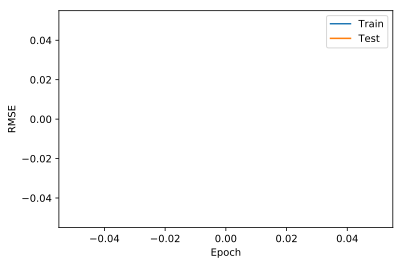

In [17]:
x_train_naval, y_train_naval, x_test_naval, y_test_naval, test_pred_naval, model_naval = train_BNN(data_naval, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

In [0]:
PICP_naval, MPIW_naval = evaluation (y_test_naval, test_pred_naval)
print ('PICP: ', PICP_naval)
print ('MPIW: ', MPIW_naval)

#Protein

In [0]:
np.random.seed(0)
url_protein = 'https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/protein.txt'
data_protein = pd.read_csv(url_protein, header=0, delimiter="\s+").values
#data = data[np.random.permutation(np.arange(len(data)))]

In [0]:
x_train_protein, y_train_protein, x_test_protein, y_test_protein, test_pred_protein, model_protein = train_BNN(data_protein, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

In [0]:
PICP_protein, MPIW_protein = evaluation (y_test_protein, test_pred_protein)
print ('PICP: ', PICP_protein)
print ('MPIW: ', MPIW_protein)

#Year prediction MSD

In [18]:
np.random.seed(0)
url_year = 'https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/year_prediction_msd.txt'
data_year = pd.read_csv(url_year, header=0, delimiter="\s+").values
print (data_year)
#data = data[np.random.permutation(np.arange(len(data)))]

[[ 4.8732150e+01  1.8429300e+01  7.0326790e+01 ...  5.8434530e+01
   2.6920610e+01  2.0010000e+03]
 [ 5.0957140e+01  3.1856020e+01  5.5818510e+01 ...  3.9670680e+01
  -6.6345000e-01  2.0010000e+03]
 [ 4.8247500e+01 -1.8983700e+00  3.6297720e+01 ...  1.9962971e+02
   1.8853820e+01  2.0010000e+03]
 ...
 [ 4.5128520e+01  1.2657580e+01 -3.8720180e+01 ...  5.3963190e+01
  -8.0936400e+00  2.0060000e+03]
 [ 4.4166140e+01  3.2383680e+01 -3.3497100e+00 ...  1.4831070e+01
   3.9749090e+01  2.0060000e+03]
 [ 5.1857260e+01  5.9116550e+01  2.6394360e+01 ...  3.2356020e+01
   1.2173520e+01  2.0050000e+03]]


In [19]:
x_train_year, y_train_year, x_test_year, y_test_year, test_pred_year, model_year = train_BNN(data_year, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

(463989, 90)
(463989, 1)
463989
51355


RuntimeError: ignored

In [0]:
PICP_year, MPIW_year = evaluation (y_test_year, test_pred_year)
print ('PICP: ', PICP_year)
print ('MPIW: ', MPIW_year)